In [53]:
# ==== Imports ====
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.colors as mcolors
from matplotlib.ticker import MultipleLocator
from pathlib import Path
import mapclassify as mc
import textwrap



In [54]:
import sys
from pathlib import Path

repo_root = Path().resolve().parents[0]
sys.path.append(str(repo_root))

print("Added to sys.path:", repo_root)

# Your helpers
from utils.common_functions import save_or_show, load_df

Added to sys.path: D:\Joe\1\Stufffs\Research\Mapping Future Skills in UK Engineering Education


In [55]:
# ==== Paths (EDIT THESE) ====
SUBJECT_PATH  = r"../data/table-28-with-subject"
LOC_PATH      = r"../data/provider-location"
ITL1_GEOJSON  = r"../data/provider-location/itl1_2025_buc.geojson"

In [56]:
def publication_rc():
    plt.rcParams.update({
        "figure.figsize": (12, 6),
        "axes.titlesize": 14,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "legend.fontsize": 10,
        "lines.linewidth": 1.0,
        "axes.titleweight": "bold",
        "axes.labelweight": "bold",
        "legend.frameon": False,
        "font.family": "DejaVu Sans",
    })


In [57]:
# ==== Helpers ====
def norm_ukprn(series: pd.Series) -> pd.Series:
    """Normalize UKPRN so 10007783.0 -> '10007783' (string)."""
    return (pd.to_numeric(series, errors="coerce")
              .astype("Int64")
              .astype(str)
              .str.replace("<NA>", "", regex=False)
              .str.strip())

In [58]:
def keep_totals_slice(df: pd.DataFrame, filters: dict) -> pd.DataFrame:
    mask = pd.Series(True, index=df.index)
    for col, value in filters.items():
        mask &= df[col].eq(value)
    return df.loc[mask].copy()

In [59]:
def mode_region(s: pd.Series):
    m = s.mode()
    return sorted(m.astype(str))[0] if len(m) else None

In [60]:
# ==== Load data ====
publication_rc()

# Subject/enrolments table (HESA-like)
df_subj = load_df(SUBJECT_PATH, skip_rows=13)

# Provider locations with LAT/LON (Discover Uni/KIS-style export you prepared)
loc_df = load_df(LOC_PATH, skip_rows=0) 

# Normalize keys
df_subj["UKPRN"] = norm_ukprn(df_subj["UKPRN"])
loc_df["UKPRN"]  = norm_ukprn(loc_df["UKPRN"])

# Basic sanity for required columns
for c in ["UKPRN", "LATITUDE", "LONGITUDE"]:
    if c not in loc_df.columns:
        raise KeyError(f"locations file missing required column: {c}")

# Drop rows with missing coordinates
loc_df = loc_df.dropna(subset=["LONGITUDE", "LATITUDE"])

In [61]:
# ==== Define your analytical scope (EDIT if needed) ====
FILTERS = {
    "Subject area of degree": "10 Engineering and technology",
    "Activity": "Total",
    "Interim study": "Include significant interim study",
    "Level of qualification obtained": "All",
    "Mode of former study": "All",
    "Academic year": "2022/23",   # <- pick your year
}

enrol = keep_totals_slice(df_subj, FILTERS)[["UKPRN", "Number"]].copy()


In [62]:
# ==== Spatial join: assign each provider location to an ITL1 (12-region) polygon ====
# 1) Points
g_loc = gpd.GeoDataFrame(
    loc_df,
    geometry=gpd.points_from_xy(loc_df["LONGITUDE"], loc_df["LATITUDE"]),
    crs="EPSG:4326"
)

# 2) Regions polygons (ITL1)
regions = gpd.read_file(ITL1_GEOJSON).to_crs("EPSG:4326")
REG_NAME_COL = next(c for c in regions.columns if c.lower().endswith("nm") or "name" in c.lower())
# clean region names
regions[REG_NAME_COL] = regions[REG_NAME_COL].str.replace(" (England)", "", regex=False)

# 3) Spatial join (use "intersects" to be robust for boundary points)
g_join = gpd.sjoin(
    g_loc,
    regions[[REG_NAME_COL, "geometry"]],
    how="left",
    predicate="intersects"
).rename(columns={REG_NAME_COL: "Provider region"})

In [63]:
# ==== Collapse to ONE region per provider (mode) ====
g_join["UKPRN"] = norm_ukprn(g_join["UKPRN"])
region_map = (g_join.dropna(subset=["Provider region"])
                    .groupby("UKPRN")["Provider region"]
                    .agg(mode_region))

In [64]:
# ==== Map region to enrol and aggregate ====
enrol2 = enrol.copy()
# Avoid duplicate columns if any
enrol2 = enrol2.loc[:, ~enrol2.columns.duplicated()].copy()
enrol2 = enrol2.drop(columns=["Provider region"], errors="ignore")
enrol2["UKPRN"] = norm_ukprn(enrol2["UKPRN"])
enrol2["Provider region"] = enrol2["UKPRN"].map(region_map)

# QA
matched_rows   = enrol2["Provider region"].notna().sum()
unmatched_rows = enrol2["Provider region"].isna().sum()
print(f"[QA] Enrol rows matched to a region: {matched_rows:,}  |  Unmatched: {unmatched_rows:,}")

if matched_rows == 0:
    raise RuntimeError("0 rows mapped to a region. Check UKPRN normalization and spatial join predicate.")

region_totals = (enrol2.dropna(subset=["Provider region"])
                         .groupby("Provider region", as_index=False)["Number"]
                         .sum()
                         .sort_values("Number", ascending=False))


[QA] Enrol rows matched to a region: 216  |  Unmatched: 42


In [65]:
region_totals.head(15)

,Provider region,Number
2,London,10755
4,North West,6755
11,Yorkshire and The Humber,6040
6,Scotland,5650
1,East Midlands,5305
7,South East,4650
10,West Midlands,4650
8,South West,4095
3,North East,3875
0,East,3300


In [66]:
# # ==== Choropleth plot ====
# def plot_choropleth_itl1(region_totals: pd.DataFrame, regions_geojson_path: str, title: str,
#                          out_basename: str, y_axis_label="Graduates", chart_dir: str = "chart-4"):
#     regions = gpd.read_file(regions_geojson_path).to_crs("EPSG:4326")
#     REG_NAME_COL = next(c for c in regions.columns if c.lower().endswith("nm") or "name" in c.lower())
#     m = regions.merge(region_totals, left_on=REG_NAME_COL, right_on="Provider region", how="left")

#     fig, ax = plt.subplots(figsize=(10, 9))
#     # draw the map WITHOUT the built-in legend
#     mp = m.plot(
#         column="Number", ax=ax, cmap="Blues",
#         linewidth=0.4, edgecolor="#666",
#         missing_kwds={"color": "lightgrey", "hatch": "///", "label": "No data"},
#         legend=False
#     )
#     ax.set_axis_off()
#     ax.set_title(title, fontweight="bold", pad=10)
    
    
#     vals = m["Number"].dropna().to_numpy()
#     vmin = float(vals.min()) if len(vals) else 0.0
#     vmax = float(vals.max()) if len(vals) else 1.0
    
#     sm = plt.cm.ScalarMappable(cmap="Blues", norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
#     sm.set_array([])  # required for older mpl versions
    
#     # fraction = bar width; pad = distance from map -> increase pad slightly to move it away
#     cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.25)
#     # top label/title
#     cbar.ax.set_title( y_axis_label, fontsize=9, fontweight="bold", pad=6)
#     # optional: thousands formatting on ticks
#     cbar.formatter = mtick.StrMethodFormatter("{x:,.0f}")
#     cbar.update_ticks()
    
#     save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [ ]:
def plot_choropleth_itl1(region_totals, regions_geojson_path, title,
                         out_basename, y_axis_label="Graduates", chart_dir="chart-4"):
    regions = gpd.read_file(regions_geojson_path).to_crs("EPSG:4326")
    REG_NAME_COL = next(c for c in regions.columns if c.lower().endswith("nm") or "name" in c.lower())
    # clean region names
    regions[REG_NAME_COL] = regions[REG_NAME_COL].str.replace(" (England)", "", regex=False)

    m = regions.merge(region_totals, left_on=REG_NAME_COL, right_on="Provider region", how="left")

    fig, ax = plt.subplots(figsize=(10, 9))

    mp = m.plot(
        column="Number", ax=ax, cmap="Blues",
        linewidth=0.4, edgecolor="#666",
        missing_kwds={"color": "lightgrey", "hatch": "///", "label": "No data"},
        legend=False
    )
    ax.set_axis_off()
    ax.set_title(title, fontweight="bold", pad=10)

    # --- add region labels ---
    m["centroid"] = m.geometry.centroid

    for _, row in m.iterrows():

    #     ax.text(
    #         row["centroid"].x,
    #         row["centroid"].y,
    #         row[REG_NAME_COL],
    #         ha="center",
    #         va="center",
    #         fontsize=8,
    #         fontweight="bold",
    #         color="black",
    #         zorder=10
    #     )
        label = textwrap.fill(row[REG_NAME_COL], width=12)

        # default positions
        x = row["centroid"].x
        y = row["centroid"].y

        # apply custom offset for North West and Walse only
        if row[REG_NAME_COL] == "North West":
            x = x - 0.7   # move left slightly
            # you can adjust 0.5 to 0.3 or 0.7 depending on how much left you need

        if row[REG_NAME_COL] == "Wales":
                    y = y - 0.7   

        ax.text(
            x, y,
            label,
            ha="center",
            va="center",
            fontsize=8,
            fontweight="bold",
            color="black",
            zorder=10
        )


    # --- custom colorbar ---
    vals = m["Number"].dropna().to_numpy()
    vmin = float(vals.min()) if len(vals) else 0.0
    vmax = float(vals.max()) if len(vals) else 1.0

    sm = plt.cm.ScalarMappable(cmap="Blues", norm=mcolors.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, fraction=0.035, pad=0.25)
    cbar.ax.set_title(y_axis_label, fontsize=9, fontweight="bold", pad=6)
    cbar.formatter = mtick.StrMethodFormatter("{x:,.0f}")
    cbar.update_ticks()

    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)


In [78]:
# ==== Bar chart by region ====
def plot_region_bar(region_totals, title, out_basename, y_axis_label="Graduates", chart_dir="chart-4"):
    r = region_totals.sort_values("Number", ascending=False).reset_index(drop=True)
    n = len(r)

    publication_rc()

    fig_w = max(10, 0.7 * n)
    fig, ax = plt.subplots(figsize=(fig_w, 6.5))

    base_palette = (
        list(plt.cm.tab20.colors) +
        list(plt.cm.Set2.colors)  +
        list(plt.cm.Paired.colors)
    )
    colors = (base_palette * ((n // len(base_palette)) + 1))[:n]

    BAR_WIDTH = 0.65
    bars = ax.bar(r["Provider region"], r["Number"], width=0.7, color=colors, linewidth=0.6)

    y_max = r["Number"].max()
    ax.set_ylim(0, y_max * 1.15)

    lbls = ax.bar_label(bars, fmt="{:,.0f}", padding=3, label_type="edge")
    for t in lbls:
        t.set_clip_on(False)
        t.set_fontsize(10)

    # ax.set_xticklabels(sub_bar["Subject"], rotation=30, ha="right")
    ax.set_xticklabels(r["Provider region"], rotation=30, ha="right")
    
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
    ax.yaxis.set_major_locator(MultipleLocator(1000))
    ax.yaxis.set_minor_locator(MultipleLocator(200))
    ax.grid(True, which="major", axis="y", linestyle="-", alpha=0.5)
    ax.grid(True, which="minor", axis="y", linestyle=":",  alpha=0.2)

    ax.set_xlabel("")
    ax.set_ylabel(y_axis_label, fontweight="bold", labelpad=8)
    ax.set_title(title, fontweight="bold", pad=12)

    plt.tight_layout()
    save_or_show(fig, out_dir=chart_dir, filename=out_basename, show=True)



C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_8972\1494521625.py:22: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m["centroid"] = m.geometry.centroid


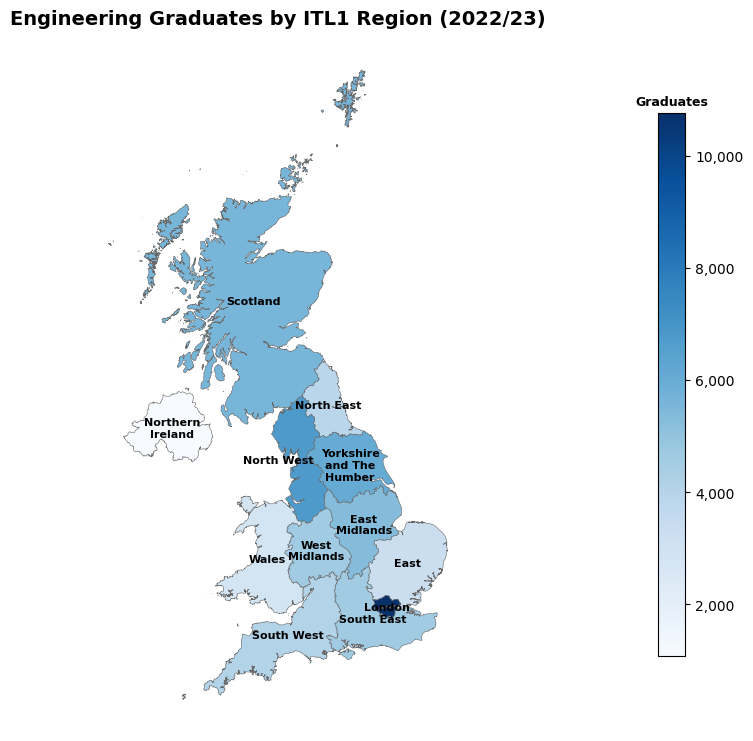

In [79]:
# ==== Run plots ====
plot_choropleth_itl1(
    region_totals,
    regions_geojson_path=ITL1_GEOJSON,
    title=f"Engineering Graduates by ITL1 Region ({FILTERS['Academic year']})",
    out_basename="eng_grads_itl1_choropleth"
)


C:\Users\faith.SCCNIG\AppData\Local\Temp\ipykernel_8972\2868473418.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(r["Provider region"], rotation=30, ha="right")


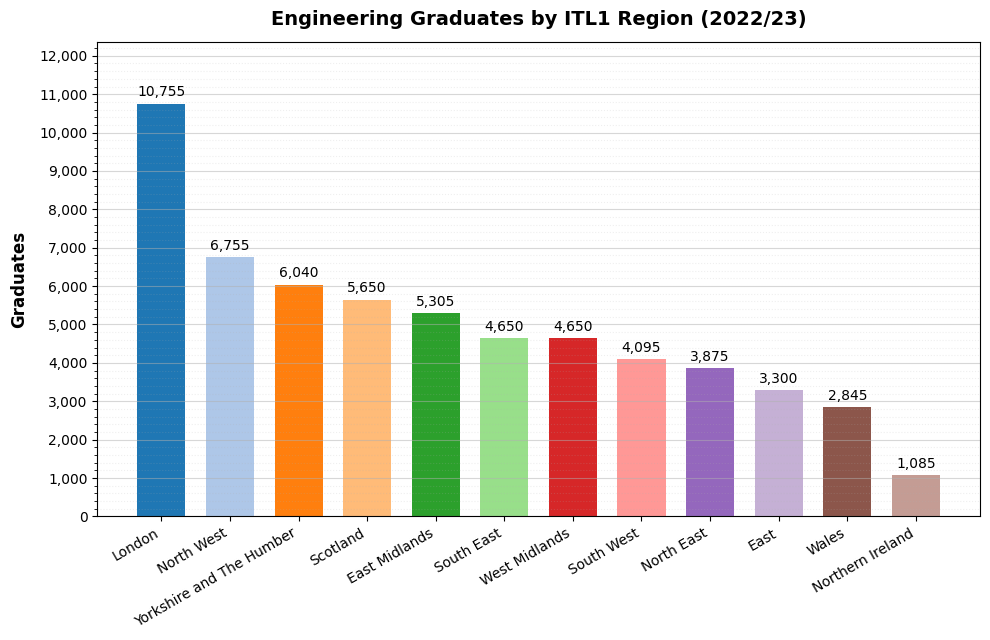

In [80]:
plot_region_bar(
    region_totals,
    title=f"Engineering Graduates by ITL1 Region ({FILTERS['Academic year']})",
    out_basename="eng_grads_itl1_bar"
)

In [81]:
print(enrol2.loc[enrol2["Provider region"].isna(), "UKPRN"].drop_duplicates().head(20))


5264      10000055
39506     10000560
49230     10000610
60410     10020680
81210     10000720
91272     10000794
98188     10000820
129167    10000952
146834    10001116
167946    10057213
188798    10005972
206738    10007822
213420    10001778
233115    10007924
266005    10006570
290549    10002638
332136    10007193
370330    10082570
388842    10003189
395082    10003753
Name: UKPRN, dtype: object
